In [2]:
import h5py
import keras
import tensorflow as tf

# Silence deprecated-function warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
# Confirming versions
print(keras.__version__, tf.__version__, h5py.__version__)

Using TensorFlow backend.


2.2.5 1.15.0 2.10.0


In [3]:
import os, glob, shutil
import openslide
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tifffile as tif
import xml.etree.ElementTree as ET
from shapely.geometry import Polygon
from skimage import draw
import tqdm.notebook as tq

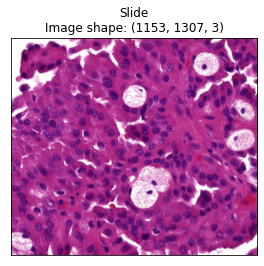

In [4]:
def from_svs(path, display = False, ax = None):
    img = openslide.OpenSlide(path)
    img = np.array(img.get_thumbnail(size = img.level_dimensions[0]), dtype = np.uint8)

    if display:
        ax.imshow(img)
        ax.set_title(f'Slide\nImage shape: {img.shape}')
        ax.set_xticks([])
        ax.set_yticks([])
    return img

sample_slides = glob.glob('./sample_original/*.svs')
_,ax = plt.subplots()
img = from_svs(sample_slides[0], True, ax)

In [5]:
def generate_and_save_masks(src = './MoNuSAC_images_and_annotations/', dst_slides = './slides/', dst_masks = './masks/', dst_annots = './annots/', RESET = False, slides = True, masks = True, annots = True):
    '''
    Generates masks for the annotations in the .xml files and saves
    them as .tif files
    Creates three directories: slides/, masks/ and annots/

    '''
    global label_mapping

    label_mapping = {
        1: 'Epithelial',
        2: 'Lymphocyte',
        3: 'Macrophage',
        4: 'Neutrophil'
    }

    if RESET:
        if slides: shutil.rmtree(dst_slides)
        if masks: shutil.rmtree(dst_masks)
        if annots: shutil.rmtree(dst_annots)

    data_path = src
    patients = [x[0] for x in os.walk(data_path)]
    try: 
        bool = True
        assert 'data' not in os.listdir()
        if slides: os.mkdir(dst_slides)
        if masks: os.mkdir(dst_masks)
        if annots: os.mkdir(dst_annots)
    except: 
        print("Destination directories already exist. Please rename or delete in case of conflicting names.")
        bool = False

    if bool:        
        count = 0
        for patient_loc in tq.tqdm(patients):
            patient_name = patient_loc[len(data_path):] #Patient name
            patient_label = patient_name[8:12]
            sub_images = glob.glob(patient_loc + '/*.svs')

            for sub_image in sub_images:
                img = openslide.OpenSlide(sub_image)
                postfix = '_' + sub_image[-5]

                if slides: shutil.copy(sub_image, './slides/' + patient_label + postfix + '.svs')

                xml_file_name  = sub_image[:-4]
                xml_file_name = xml_file_name+'.xml'
                if annots: shutil.copy(xml_file_name, dst_annots + patient_label + postfix + '.xml')
                tree = ET.parse(xml_file_name)
                root = tree.getroot()

                for k in range(len(root)):
                    label = [i.attrib['Name'] for i in root[k][0]]
                    label = label[0]

                    label_postfix = {
                        'Epithelial': '1',
                        'Lymphocyte': '2',
                        'Macrophage': '3',
                        'Neutrophil': '4',
                        'Description': 'X'
                    }

                    for child in root[k]:
                        for x in child:
                            r = x.tag
                            if r == 'Attribute':
                                count += 1
                                label = x.attrib['Name']
                                binary_mask = np.transpose(np.zeros((img.read_region((0,0),0,img.level_dimensions[0]).size))) 

                                cell_type_dir = dst_masks + label_postfix[label]
                                try: os.mkdir(cell_type_dir)
                                except: pass

                            if r == 'Region':
                                regions = []
                                vertices = x[1]
                                coords = np.zeros((len(vertices), 2))
                                for i, vertex in enumerate(vertices):
                                    coords[i][0] = vertex.attrib['X']
                                    coords[i][1] = vertex.attrib['Y']
                                regions.append(coords)
                                polygon = Polygon(coords)

                                vertex_row_coords = coords[:,0]
                                vertex_col_coords = coords[:,1]
                                fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                                
                                binary_mask[fill_row_coords, fill_col_coords] = 1
                                mask_path = cell_type_dir + '/' + label + '_' + patient_label + postfix  + '.tif'
                                if masks: cv2.imwrite(mask_path, binary_mask)

data_path = './MoNuSAC_images_and_annotations/'
generate_and_save_masks(src = data_path, 
               RESET = False, 
               slides = True,
               masks = True, 
               annots = True
               )

Destination directories already exist. Please rename or delete in case of conflicting names.


In [6]:
def arrange_directory(bool, dst = './data/'):
    if bool:
        try:
            os.mkdir(dst)
            shutil.move('./slides/', dst + 'slides/')
            shutil.move('./annots/', dst + 'annots/')
            shutil.move('./masks/', dst  + 'masks/')    
        except:
            print("Destination directory ./data/ exists. Please change the dst argument in the functino call or rename/delete the already existing directory")

arrange_directory(True)

Destination directory ./data/ exists. Please change the dst argument in the functino call or rename/delete the already existing directory


The working directory structure should now look like:
```
.
├───data
│   ├───annots
│   ├───masks
│   │   ├───1
│   │   ├───2
│   │   ├───3
│   │   ├───4
│   │   └───X
│   └───slides
├───MoNuSAC_images_and_annotations
├───sample_original
└───monusac.ipynb (current notebook)
```



In [7]:
SLIDES_DIR = './data/slides/'
SLIDES = [SLIDES_DIR + filename for filename in os.listdir('./data/slides')]

MASKS_TYPE = dict()
MASKS_ALL = []
MASKS_DIR = './data/masks/'
for i in np.arange(1,5): 
    MASKS_TYPE[i] =  [MASKS_DIR + str(i) + '/' + filename for filename in [x[2] for x in os.walk('./data/masks')][i]]
    MASKS_ALL = MASKS_ALL + MASKS_TYPE[i]

ANNOTS_DIR = './data/annots/'
ANNOTS = [ANNOTS_DIR + filename for filename in os.listdir('./data/annots')]

In [8]:
def tif_show(path, ax):
    img = tif.imread(path)
    ax.imshow(img, cmap = "Greys")
    ax.set_title("Mask" + " " + path[-10:-4] + "\n" + label_mapping[int(path[13])])
    ax.set_xticks([])
    ax.set_yticks([])

def find_in_list(id, list):
    indices = []
    for i in range(len(list)):
        if id in list[i]: indices.append(i)

    return [list[i] for i in indices]

In [9]:
find_in_list('7220_2', MASKS_ALL)

['./data/masks/2/Lymphocyte_7220_2.tif',
 './data/masks/3/Macrophage_7220_2.tif',
 './data/masks/4/Neutrophil_7220_2.tif']

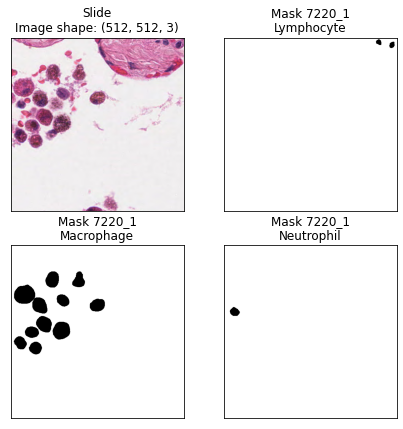

In [10]:
fig, axes = plt.subplots(2,2,figsize=(7,7))
from_svs(find_in_list('7220_1', SLIDES)[0], display = True, ax = axes[0,0])
for i, loc in zip(find_in_list('7220_1', MASKS_ALL), [(0,1), (1,0), (1,1)]):
    tif_show(i, axes[loc])

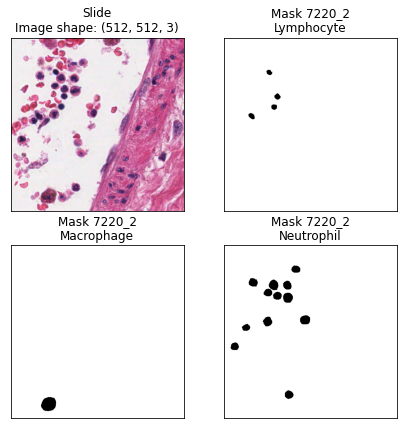

In [11]:
fig, axes = plt.subplots(2,2,figsize=(7,7))
from_svs(find_in_list('7220_2', SLIDES)[0], display = True, ax = axes[0,0])
for i, loc in zip(find_in_list('7220_2', MASKS_ALL), [(0,1), (1,0), (1,1)]):
    tif_show(i, axes[loc])

In [12]:
def tif_load(path):
    img = tif.imread(path)
    return img.reshape(img.shape[0], img.shape[1], 1)

In [13]:
SLIDES[0][-10:-4]

'1594_1'

In [14]:
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
from mrcnn import visualize

In [137]:
class MonuData(Dataset):
    ANNOTS_DIR = './data/annots/'
    MASKS_DIR = './data/masks/'
    SLIDES_DIR = './data/slides/'

    def load(self, train):
        self.add_class("cell", 1, "Epithelial")
        self.add_class("cell", 2, "Lymphocyte")
        self.add_class("cell", 3, "Macrophage")
        self.add_class("cell", 4, "Neutrophil")

        slides_list = os.listdir(SLIDES_DIR)
        train_len = int(0.8 * len(slides_list))

        for filename, idx in zip(slides_list, np.arange(len(slides_list))):
            image_id = idx
            patient_id = filename[:-4] 
            img_path = SLIDES_DIR + filename
            annot_path = ANNOTS_DIR + patient_id + '.xml'
            mask_path = MASKS_DIR

            if train and idx > train_len:
                continue
            if not train and idx < train_len + 1:
                continue
            
            self.add_image('cell', 
                           image_id = image_id, 
                           patient_id = patient_id, 
                           path = img_path, 
                           annotation = annot_path, 
                           mask = mask_path)
    
    def load_image(self, image_id, display = False, ax = None):
        info = self.image_info[image_id]
        svs_path = info['path']
        img = from_svs(svs_path, display = display, ax = ax)
        return img

    def load_mask(self, image_id):
        label_id = {
                'Epithelial': 1,
                'Lymphocyte': 2,
                'Macrophage': 3,
                'Neutrophil': 4
                }
                
        info = self.image_info[image_id]

        if info["source"] != 'cell':
            return super(self.__class__, self).load_mask(image_id)

        id = info['patient_id']
        annotations_path = info['annotation']

        tree = ET.parse(annotations_path)
        root = tree.getroot()
        img = self.load_image(image_id)
        masks = dict()
        labels = dict()

        for k in range(len(root)):
            for child in root[k]:
                for x in child:
                    r = x.tag
                    if r == 'Attribute':
                        label = x.attrib['Name']
                        binary_mask = np.zeros((img.shape[0], img.shape[1], 1), dtype = np.uint8) 

                    if r == 'Region':
                        regions = []
                        vertices = x[1]
                        coords = np.zeros((len(vertices), 2))
                        for i, vertex in enumerate(vertices):
                            coords[i][0] = vertex.attrib['X']
                            coords[i][1] = vertex.attrib['Y']
                        regions.append(coords)

                        vertex_row_coords = coords[:,0]
                        vertex_col_coords = coords[:,1]
                        fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)
                        
                        binary_mask[fill_row_coords, fill_col_coords] = 1
            masks[k] = binary_mask
            labels[k] = label
            
        keys = list(masks.keys())
        #print(keys)
        for i in keys:
            ls = []
            for j in range(len(masks[i])):
                ls.append(1 in masks[i][j])
            if True not in ls:
                del masks[i]
                del labels[i]

        net_mask = masks[list(masks.keys())[0]]
        net_labels = [label_id[labels[list(masks.keys())[0]]]]
        for i in list(masks.keys())[1:]:
            net_mask = np.concatenate((net_mask, masks[i]), axis = 2)
            net_labels.append(label_id[labels[i]])
        #print(net_mask.shape)
        #print(np.dsplit(net_mask, net_mask.shape[2]).shape)
        
        return net_mask.astype(np.bool_), np.array(net_labels)

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        print(info)
        return info['path']#

In [138]:
train_dataset = MonuData()
train_dataset.load(train = True)
train_dataset.prepare()

val_dataset = MonuData()
val_dataset.load(train = False)
val_dataset.prepare()

In [148]:
# Confirming that the load_mask function works as intended

print(train_dataset.load_mask(2)[0].shape, 
      train_dataset.load_mask(2)[1],
      train_dataset.image_info[2], sep = '\n')

print(find_in_list(train_dataset.image_info[2]['patient_id'], MASKS_ALL))

(512, 512, 2)
[2 3]
{'id': 2, 'source': 'cell', 'path': './data/slides/1594_3.svs', 'patient_id': '1594_3', 'annotation': './data/annots/1594_3.xml', 'mask': './data/masks/'}
['./data/masks/2/Lymphocyte_1594_3.tif', './data/masks/3/Macrophage_1594_3.tif']


As we can see above, 2 masks are created using the train_dataset.load_mask function for that image, and there are exactly 2 masks present in the directory whose paths are stored in MASKS_ALL

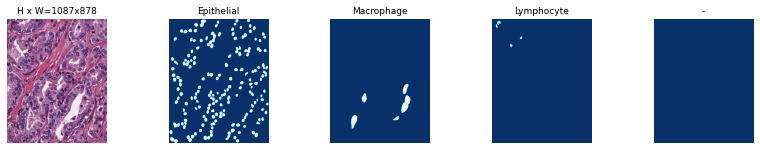

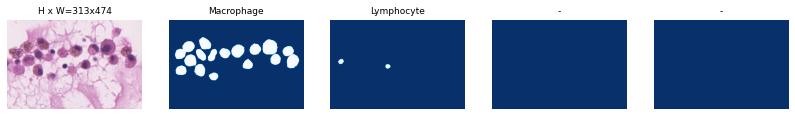

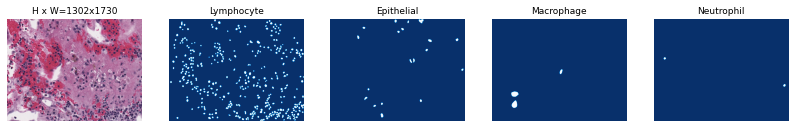

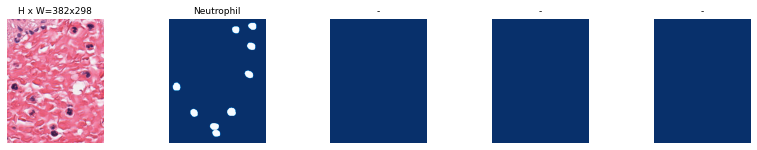

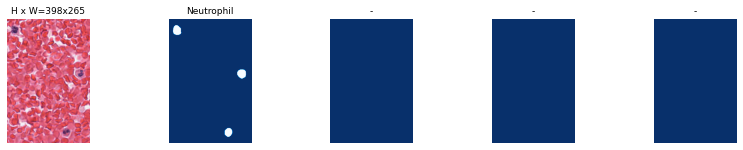

In [149]:
image_ids = np.random.choice(train_dataset.image_ids, 5)
for image_id in image_ids:
    image = train_dataset.load_image(image_id)
    mask, class_ids = train_dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, train_dataset.class_names)

In [21]:
'''tree = ET.parse('./data/annots/1594_1.xml')
root = tree.getroot()
masks = dict()

img = from_svs('./data/slides/1594_1.svs')
for k in range(len(root)):
    for child in root[k]:
        for x in child:
            r = x.tag
            if r == 'Attribute':
                label = x.attrib['Name']
                binary_mask = np.zeros(img.shape[:2])

            if r == 'Region':
                regions = []
                vertices = x[1]

                coords = np.zeros((len(vertices), 2))
                for i, vertex in enumerate(vertices):
                    coords[i][0] = vertex.attrib['X']
                    coords[i][1] = vertex.attrib['Y']
                regions.append(coords)
                polygon = Polygon(coords)

                vertex_row_coords = coords[:,0]
                vertex_col_coords = coords[:,1]
                fill_row_coords, fill_col_coords = draw.polygon(vertex_col_coords, vertex_row_coords, binary_mask.shape)

                binary_mask[fill_row_coords, fill_col_coords] = 1
    masks[k] = binary_mask
    print(label)

    #plt.imshow(binary_mask)
    #plt.show()
    #print("Mask generated")'''
print(None)

None


In [151]:
class MonuConfig(Config):
    NAME = 'MoNuSAC'
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 4     # Background + 4 cell types
    STEPS_PER_EPOCH = 100
    DETECTION_MIN_CONFIDENCE = 0.8
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 512

cfg = MonuConfig()
cfg.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.8
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                17
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [152]:
model = MaskRCNN(mode = "training", config = cfg, model_dir = './logs')
model.load_weights('../mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

In [154]:
model.train(train_dataset, 
            val_dataset, 
            learning_rate = cfg.LEARNING_RATE, 
            epochs = 5, 
            layers = 'heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: ./logs\monusac20211203T0103\mask_rcnn_monusac_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Time

c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\Users\bhavy\MoNuSAC-Instance-Segmentation\monusac\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/5
100/100 [==============================] - 141s 1s/step - loss: 2.4444 - rpn_class_loss: 0.1201 - rpn_bbox_loss: 0.8860 - mrcnn_class_loss: 0.1620 - mrcnn_bbox_loss: 0.6654 - mrcnn_mask_loss: 0.6109 - val_loss: 1.5949 - val_rpn_class_loss: 0.0741 - val_rpn_bbox_loss: 0.4098 - val_mrcnn_class_loss: 0.1253 - val_mrcnn_bbox_loss: 0.5193 - val_mrcnn_mask_loss: 0.4665
Epoch 2/5
100/100 [==============================] - 112s 1s/step - loss: 1.4693 - rpn_class_loss: 0.1014 - rpn_bbox_loss: 0.4469 - mrcnn_class_loss: 0.1208 - mrcnn_bbox_loss: 0.4047 - mrcnn_mask_loss: 0.3956 - val_loss: 1.5780 - val_rpn_class_loss: 0.0784 - val_rpn_bbox_loss: 0.5282 - val_mrcnn_class_loss: 0.1220 - val_mrcnn_bbox_loss: 0.3562 - val_mrcnn_mask_loss: 0.4932
Epoch 3/5
100/100 [==============================] - 111s 1s/step - loss: 1.3397 - rpn_class_loss: 0.0712 - rpn_bbox_loss: 0.3846 - mrcnn_class_loss: 0.1348 - mrcnn_bbox_loss: 0.3406 - mrcnn_mask_loss: 0.4085 - val_loss: 1.3272 - val_rpn_class_loss